In [10]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vencerlanz09/plastic-paper-garbage-bag-synthetic-images

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images
License(s): CC-BY-SA-4.0
... resuming from 440401920 bytes (32853149 bytes left) ...
 97% 439M/451M [00:00<00:00, 93.1MB/s]
100% 451M/451M [00:00<00:00, 105MB/s] 


In [ ]:
!unzip plastic-paper-garbage-bag-synthetic-images.zip

# 🛍️Disposable Bags Classification using Deep Convolutional Neural Networks and Transfer Learning

## 🔬Overview
In the advancements of Artificial Intelligence(AI) and further development of sophisticated deep learning models, it is important for us to develop Computer Vision algorithms that could classify different domain of objects. In this case, disposable bags classification can be beneficial especially in use-cases like recycling, cleaning, or waste segregation.

## 💡Inspiration:
This is one of my personal projects that I would like to try for a while now. I've always been meaning to create a CV application that can be useful for waste segregation, recycling and others.

## ❗Author's Note:
Make sure to run the cells from top to bottom with a GPU accelerator. There are some linux commands present in some cells so this is important to take into account. Also, any suggestions, comments and recommendations to improve the notebook will be highly appreciated. Cheers!



# 🏗️Import Necessary Libraries

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image

# 🤙Create helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-07-21 08:45:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-21 08:45:41 (20.0 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



# 📥Load and Transform Data

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [5]:
# Walk through each directory
dataset = "/content/Bag Classes"
walk_through_dir(dataset)

There are 1 directories and 0 images in '/content/Bag Classes'.
There are 3 directories and 0 images in '/content/Bag Classes/Bag Classes'.
There are 0 directories and 5000 images in '/content/Bag Classes/Bag Classes/Paper Bag Images'.
There are 0 directories and 5000 images in '/content/Bag Classes/Bag Classes/Plastic Bag Images'.
There are 0 directories and 5000 images in '/content/Bag Classes/Bag Classes/Garbage Bag Images'.


# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [6]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
filepaths

0        /content/Bag Classes/Bag Classes/Paper Bag Ima...
1        /content/Bag Classes/Bag Classes/Paper Bag Ima...
2        /content/Bag Classes/Bag Classes/Paper Bag Ima...
3        /content/Bag Classes/Bag Classes/Paper Bag Ima...
4        /content/Bag Classes/Bag Classes/Paper Bag Ima...
                               ...                        
14995    /content/Bag Classes/Bag Classes/Garbage Bag I...
14996    /content/Bag Classes/Bag Classes/Garbage Bag I...
14997    /content/Bag Classes/Bag Classes/Garbage Bag I...
14998    /content/Bag Classes/Bag Classes/Garbage Bag I...
14999    /content/Bag Classes/Bag Classes/Garbage Bag I...
Name: Filepath, Length: 15000, dtype: object

In [8]:
image_df

,Filepath,Label
0,/content/Bag Classes/Bag Classes/Paper Bag Ima...,Paper Bag Images
1,/content/Bag Classes/Bag Classes/Paper Bag Ima...,Paper Bag Images
2,/content/Bag Classes/Bag Classes/Paper Bag Ima...,Paper Bag Images
3,/content/Bag Classes/Bag Classes/Paper Bag Ima...,Paper Bag Images
4,/content/Bag Classes/Bag Classes/Paper Bag Ima...,Paper Bag Images
...,...,...
14995,/content/Bag Classes/Bag Classes/Garbage Bag I...,Garbage Bag Images
14996,/content/Bag Classes/Bag Classes/Garbage Bag I...,Garbage Bag Images
14997,/content/Bag Classes/Bag Classes/Garbage Bag I...,Garbage Bag Images
14998,/content/Bag Classes/Bag Classes/Garbage Bag I...,Garbage Bag Images


# 🔭Visualizing images from the dataset

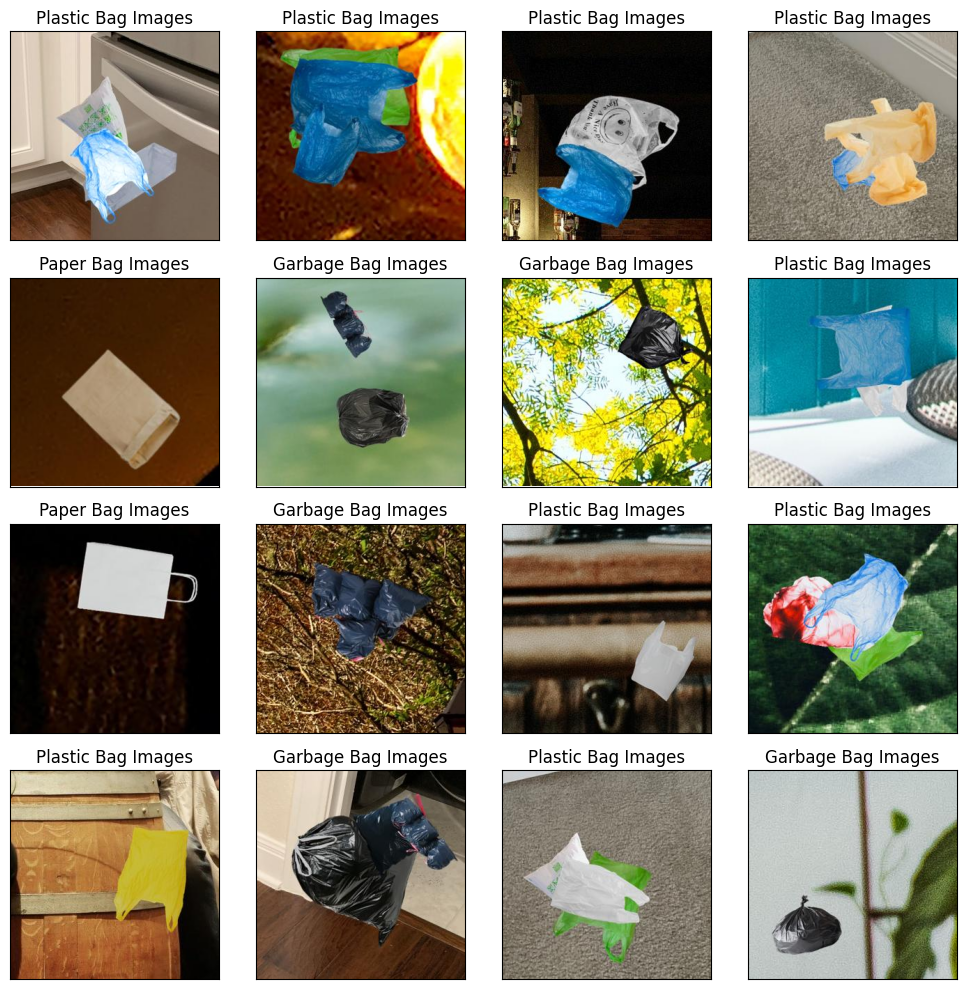

In [9]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 📝Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 9600 validated image filenames belonging to 3 classes.
Found 2400 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [13]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# 🤹Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (300, 300, 3)

**Output layer** : 5



In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [15]:
# Create checkpoint callback
checkpoint_path = "bags_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [26]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Training the model

In [ ]:


inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "bag_classification"),
        checkpoint_callback,
    ]
)

# ✔️Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**:
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**:
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**:
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# 📉Visualizing loss curves

In [ ]:
plot_loss_curves(history)

# 🔮Making predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [16]:
imagesTest = Path("/content/ImageClassesCombinedWithCOCOAnnotations/images_raw")
images = list(imagesTest.glob(r'**/*.jpg'))
images = pd.Series(images, name='Filepath').astype(str)
images = pd.DataFrame(images)
images = test_generator.flow_from_dataframe(
    dataframe=images,
    x_col='Filepath',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,
    batch_size=32,
    shuffle=False
)


Found 15000 validated image filenames.


In [ ]:
images.filepaths

In [18]:
model_saved = load_model("bag_classification_model.h5")

In [19]:
y_predict = model_saved.predict(images)

469/469 [==============================] - 639s 1s/step


In [20]:
y_predict = np.argmax(y_predict,axis=1)

In [21]:
categ = (train_images.class_indices)
categ = dict((v,k) for k,v in categ.items())
y_predict = [categ[k] for k in y_predict]

In [22]:
len(y_predict)

15000

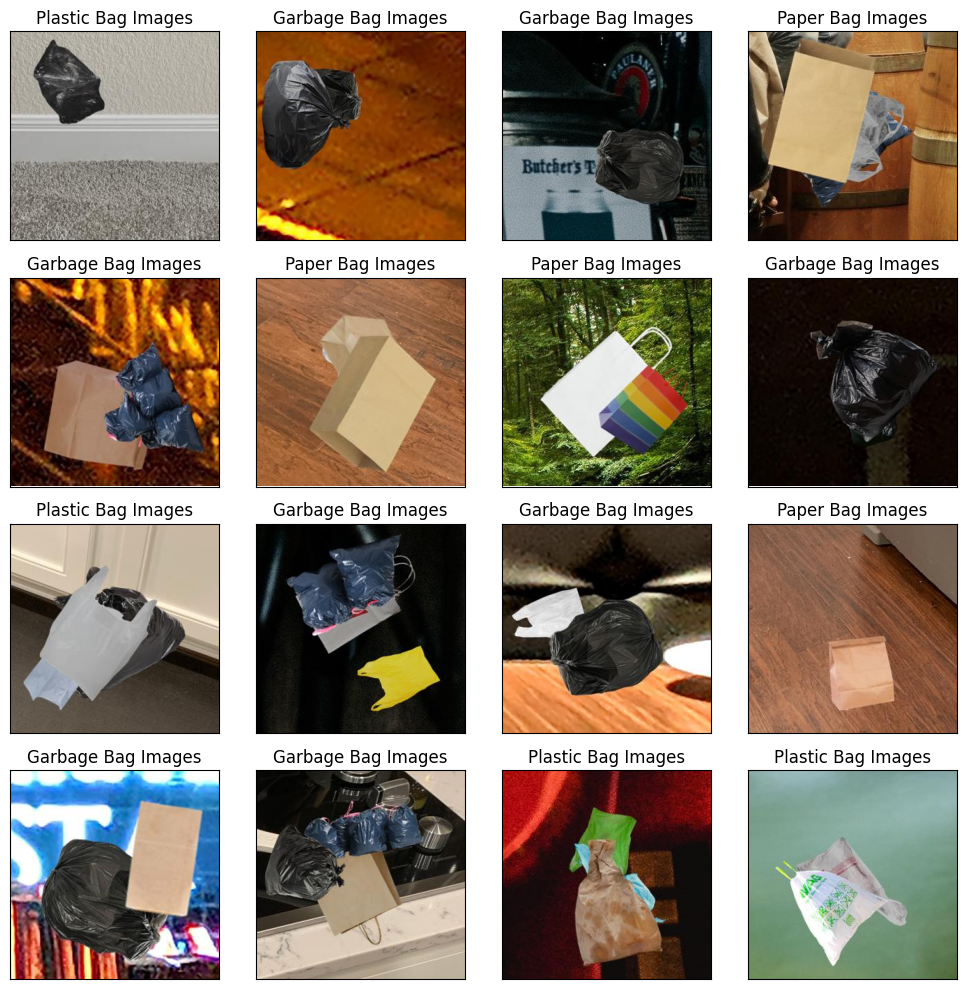

In [28]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images.filepaths[random_index[i]]))
    ax.set_title(y_predict[random_index[i]])
plt.tight_layout()
plt.show()